# Trabalho de Redes Neurais

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem as al
from rdkit.Chem import Draw, AllChem, Descriptors
from cod_izaque import converte
import numpy as np
from sklearn.model_selection import train_test_split
import lightning as L
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Adquirindo os dados

Os nossos dados adveêm do site `Kaggle` e fazem parte da tarefa: `Metal-Organic Frame Materials Prediction`

In [3]:
dados_treino_finger = pd.read_csv(r"dados_treino\finger_train.csv", sep=',', header=0)
dados_treino_RAC = pd.read_csv(r"dados_treino\RAC_train.csv", sep=',', header=0)
dados_teste_RAC = pd.read_csv(r"dados_teste\RAC_test.csv", sep=',', header=0)
dados_teste_finger = pd.read_csv(r"dados_teste\finger_test.csv", sep=',', header=0)
dados_conf_ele_correct = pd.read_csv("electronic_configuration.csv", sep=',', header=0)

In [4]:
dados_treino_finger

,mof,1s,2s,3s,4s,5s,6s,7s,2p,3p,...,4d,5d,6d,4f,5f,metal,linker1smi,oxidation_state,temperature,time
0,WIRMOB_clean,2,2,2,2,0,0,0,6,6,...,0,0,0,0,0,Zn,O=C(O)c1ccc(COc2c3c(c(OCc4ccc(C(=O)O)cc4)c4c2C...,2,110,72.0
1,VIXTUT_clean,2,2,2,2,0,0,0,6,6,...,0,0,0,0,0,Zn,c1cc(CCc2ccncc2)ccn1,2,85,72.0
2,PODKUQ_clean,2,2,2,1,0,0,0,6,6,...,0,0,0,0,0,Cu,O=C(O)c1cc(C(=O)O)cc(-n2cc(-c3ccc(-c4cc(-c5ccc...,2,80,24.0
3,IKUTOZ_clean,2,2,2,2,2,2,0,6,6,...,10,0,0,10,0,Dy,O=C(O)c1c2ccccc2c(C(=O)O)c2ccccc12,3,95,24.0
4,LADHEF_clean,2,2,2,2,0,0,0,6,6,...,0,0,0,0,0,Zn,c1nnc[nH]1,2,80,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,132,2,2,2,2,2,0,0,6,6,...,2,0,0,0,0,Zr,[O]c1c(c2ccc(cc2)C(=O)[O-])c2ccc3c4c2c(c1c1ccc...,4,120,72.0
556,57,2,2,2,2,0,0,0,6,6,...,0,0,0,0,0,Zn,[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-],2,75,96.0
557,58,2,2,2,2,0,0,0,6,6,...,0,0,0,0,0,Fe,[O-]C(=O)C1=CC2=C3C=C(C=C3c3c([C]2S1)sc(c3)C(=...,3,120,120.0
558,26,2,2,2,2,2,2,2,6,6,...,10,10,2,14,0,Th,[O-]C(=O)C1=[C][C]=C([C]=[C]1)C(=O)[O-],4,120,24.0


## Identificando Dados presentes em ambos DFs

In [5]:
def enc_intersection(dados1, dados2):
    a = set(list(dados1))
    b = set(list(dados2))
    
    c = a.intersection(b)
    
    return c

In [6]:
intercecao_treino = enc_intersection(dados_treino_finger['mof'].values, dados_treino_RAC['mof'].values)
intercecao_teste = enc_intersection(dados_teste_finger['mof'].values, dados_teste_RAC['mof'].values)

In [7]:
#aplicando filtro para 
dados_fingertrain_filtrado = dados_treino_finger.loc[dados_treino_finger['mof'].isin(intercecao_treino)] #referncia: https://pt.stackoverflow.com/questions/309037/filtrar-linhas-no-pandas-por-uma-lista
dados_ractrain_filtrado = dados_treino_RAC.loc[dados_treino_RAC['mof'].isin(intercecao_treino)]
dados_fingertest_filtrado = dados_teste_finger.loc[dados_teste_finger['mof'].isin(intercecao_teste)] #referncia: https://pt.stackoverflow.com/questions/309037/filtrar-linhas-no-pandas-por-uma-lista
dados_ractest_filtrado = dados_teste_RAC.loc[dados_teste_RAC['mof'].isin(intercecao_teste)]

## Verificando o tipo de dado no DataFrame

In [8]:
dados_treino_finger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mof              560 non-null    object 
 1   1s               560 non-null    int64  
 2   2s               560 non-null    int64  
 3   3s               560 non-null    int64  
 4   4s               560 non-null    int64  
 5   5s               560 non-null    int64  
 6   6s               560 non-null    int64  
 7   7s               560 non-null    int64  
 8   2p               560 non-null    int64  
 9   3p               560 non-null    int64  
 10  4p               560 non-null    int64  
 11  5p               560 non-null    int64  
 12  6p               560 non-null    int64  
 13  3d               560 non-null    int64  
 14  4d               560 non-null    int64  
 15  5d               560 non-null    int64  
 16  6d               560 non-null    int64  
 17  4f              

In [9]:
dados_treino_RAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Columns: 354 entries, mof to additive_category
dtypes: float64(260), int64(93), object(1)
memory usage: 1.5+ MB


In [10]:
dados_teste_finger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mof              140 non-null    int64 
 1   1s               140 non-null    int64 
 2   2s               140 non-null    int64 
 3   3s               140 non-null    int64 
 4   4s               140 non-null    int64 
 5   5s               140 non-null    int64 
 6   6s               140 non-null    int64 
 7   7s               140 non-null    int64 
 8   2p               140 non-null    int64 
 9   3p               140 non-null    int64 
 10  4p               140 non-null    int64 
 11  5p               140 non-null    int64 
 12  6p               140 non-null    int64 
 13  3d               140 non-null    int64 
 14  4d               140 non-null    int64 
 15  5d               140 non-null    int64 
 16  6d               140 non-null    int64 
 17  4f               140 non-null    in

In [11]:
dados_teste_RAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Columns: 342 entries, mof to CH4HPSTP
dtypes: float64(255), int64(87)
memory usage: 358.2 KB


### Encontrando os dados `object` e convertendo

In [12]:
dados_treino_finger.select_dtypes(include='object')

,mof,metal,linker1smi
0,WIRMOB_clean,Zn,O=C(O)c1ccc(COc2c3c(c(OCc4ccc(C(=O)O)cc4)c4c2C...
1,VIXTUT_clean,Zn,c1cc(CCc2ccncc2)ccn1
2,PODKUQ_clean,Cu,O=C(O)c1cc(C(=O)O)cc(-n2cc(-c3ccc(-c4cc(-c5ccc...
3,IKUTOZ_clean,Dy,O=C(O)c1c2ccccc2c(C(=O)O)c2ccccc12
4,LADHEF_clean,Zn,c1nnc[nH]1
...,...,...,...
555,132,Zr,[O]c1c(c2ccc(cc2)C(=O)[O-])c2ccc3c4c2c(c1c1ccc...
556,57,Zn,[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-]
557,58,Fe,[O-]C(=O)C1=CC2=C3C=C(C=C3c3c([C]2S1)sc(c3)C(=...
558,26,Th,[O-]C(=O)C1=[C][C]=C([C]=[C]1)C(=O)[O-]


In [13]:
dados_treino_RAC.select_dtypes(include='object')

,mof
0,QUHMOX_clean
1,VOLPET_clean
2,XUHVON_clean
3,KIDDOS_clean
4,FURFOP_clean
...,...
532,MAYKOO_clean
533,ADASEF_clean
534,KUQWIE_clean
535,WONBAD_clean


In [14]:
dados_teste_finger.select_dtypes(include='object')

,metal,linker1smi
0,Zn,Nc1ncnc2nc[nH]c12
1,Cu,O=C(O)c1cc(C(=O)O)cc(-c2cc(-c3cc(C(=O)O)cc(C(=...
2,Mg,O=C(O)c1ccc2cc(C(=O)O)ccc2c1
3,Gd,O=C(O)c1ccc2[nH]c(-c3ccc(-c4nc5ccc(C(=O)O)cc5[...
4,Cu,O=C(O)c1cncc(C(=O)O)c1
...,...,...
135,Zr,Cc1cc(ccc1c1ccc(cc1C)C(=O)[O-])C(=O)[O-]
136,Fe,[O-]C(=O)c1ccc(cc1)N=Nc1ccc(cc1)C(=O)[O-]
137,Th,[O-]C(=O)C1=[C][C]=C([C]=[C]1)C(=O)[O-]
138,Fe,Nc1c(cc(cc1c1ccc(cc1)C(=O)[O-])c1ccc(cc1)C(=O)...


As colunas que o pandas identifica como do tipo `object` são todas do tipo `string`. Vamos convertê-las.

In [15]:
lista = ['mof', 'metal', 'linker1smi']
for coluna in lista:
    dados_treino_finger[coluna] = converte(dados_treino_finger[coluna], 'string')
    
dados_treino_RAC[lista[0]] = converte(dados_treino_RAC[lista[0]], 'string')
lista.remove('mof')
for coluna in lista:
    dados_teste_finger[coluna] = converte(dados_teste_finger[coluna], 'string')

## Verificando presença de dados não preenchidos

In [17]:
dados_treino_finger.isnull().sum()

mof                0
1s                 0
2s                 0
3s                 0
4s                 0
5s                 0
6s                 0
7s                 0
2p                 0
3p                 0
4p                 0
5p                 0
6p                 0
3d                 0
4d                 0
5d                 0
6d                 0
4f                 0
5f                 0
metal              0
linker1smi         0
oxidation_state    0
temperature        0
time               0
dtype: int64

In [18]:
dados_treino_RAC.isnull().sum()

mof                  0
ASA [m^2/cm^3]       0
CellV [A^3]          0
Df                   0
Di                   0
                    ..
param2               0
param3               0
param4               0
param5               0
additive_category    0
Length: 354, dtype: int64

## Antes da diversão, alguns ajustes...

Para a implementação do `VIF` é necessário dados numéricos e nosso dataset possui uma mescla de dados str e dados int/float. Alguns dados str/object devem ser mantidos e para isso vamos realizar uma conversão simbólico-numérico, este é o caso do `metal`. A coluna `linker1smi` será transformada em um número com o auxílio da biblioteca `rdkit` com o módulo `Chem`.

In [19]:
lista_rac = list(dados_treino_RAC.columns)
lista_rac.remove('mof')

In [20]:
lista= list(dados_treino_finger.columns)
lista.remove('mof')

In [21]:
ordenador = set(dados_treino_finger[lista[lista.index('metal')]].values)
ordenador= list(ordenador)
ordenadory = set(dados_teste_finger[lista[lista.index('metal')]].values)
ordenadory= list(ordenador)
treino_finger_cp = dados_treino_finger[lista]
treino_rac_cp = dados_treino_RAC[lista_rac]
teste_finger_cp = dados_treino_finger[lista]
teste_rac_cp = dados_treino_RAC[lista_rac]

In [22]:
from sklearn.preprocessing import OrdinalEncoder

def conversao_ordinal(x, ordem):
    
    encoder = OrdinalEncoder(categories=ordem)

    encoder.fit(x)

    dados_convertidos = encoder.transform(x)

    return dados_convertidos

In [23]:
x = treino_finger_cp["metal"].values.reshape(-1, 1)
y = teste_finger_cp["metal"].values.reshape(-1, 1)
ordem = [ordenador] 
ordemy = [ordenadory] 

treino_finger_cp['metal'] = conversao_ordinal(x, ordem)
teste_finger_cp['metal'] = conversao_ordinal(y, ordemy)

C:\Users\caued\AppData\Local\Temp\ipykernel_520\4185046301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino_finger_cp['metal'] = conversao_ordinal(x, ordem)
C:\Users\caued\AppData\Local\Temp\ipykernel_520\4185046301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste_finger_cp['metal'] = conversao_ordinal(y, ordemy)


In [24]:
treino_finger_cp

,1s,2s,3s,4s,5s,6s,7s,2p,3p,4p,...,4d,5d,6d,4f,5f,metal,linker1smi,oxidation_state,temperature,time
0,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,0,5.0,O=C(O)c1ccc(COc2c3c(c(OCc4ccc(C(=O)O)cc4)c4c2C...,2,110,72.0
1,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,0,5.0,c1cc(CCc2ccncc2)ccn1,2,85,72.0
2,2,2,2,1,0,0,0,6,6,0,...,0,0,0,0,0,17.0,O=C(O)c1cc(C(=O)O)cc(-n2cc(-c3ccc(-c4cc(-c5ccc...,2,80,24.0
3,2,2,2,2,2,2,0,6,6,6,...,10,0,0,10,0,10.0,O=C(O)c1c2ccccc2c(C(=O)O)c2ccccc12,3,95,24.0
4,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,0,5.0,c1nnc[nH]1,2,80,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,2,2,2,0,0,6,6,6,...,2,0,0,0,0,2.0,[O]c1c(c2ccc(cc2)C(=O)[O-])c2ccc3c4c2c(c1c1ccc...,4,120,72.0
556,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,0,5.0,[O-]C(=O)C1=C[C]=CC(=C1)C(=O)[O-],2,75,96.0
557,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,0,7.0,[O-]C(=O)C1=CC2=C3C=C(C=C3c3c([C]2S1)sc(c3)C(=...,3,120,120.0
558,2,2,2,2,2,2,2,6,6,6,...,10,10,2,14,0,13.0,[O-]C(=O)C1=[C][C]=C([C]=[C]1)C(=O)[O-],4,120,24.0


## Atenção!
Os códigos abaixo que dizem respeito à exploração dos dados contidos na coluna `linker1smi` foram baseados nos códigos de um usuário do KAGGLE `Marquis03`.

## Testando o que o Marquis03 fez

In [25]:
df_train = treino_finger_cp.copy()
fingerprint = lambda x: al.GetMorganFingerprintAsBitVect(x, 3)

In [26]:
mol1 = df_train["linker1smi"].apply(Chem.MolFromSmiles)
fingerprint1 = np.array(mol1.apply(fingerprint).tolist())
fingerprint1 = pd.DataFrame(fingerprint1).add_prefix("fp1_")
fingerprint1.index = df_train.index
df_train.drop(['linker1smi'], axis=1, inplace=True)
df_train = pd.concat([df_train, fingerprint1], axis=1)

In [27]:
df_train['MolWt'] = mol1.apply(Descriptors.ExactMolWt)
df_train['TPSA'] = mol1.apply(Chem.rdMolDescriptors.CalcTPSA)
df_train['nRotB'] = mol1.apply(Descriptors.NumRotatableBonds)
df_train['HBD'] = mol1.apply(Descriptors.NumHDonors)
df_train['HBA'] = mol1.apply(Descriptors.NumHAcceptors)
df_train['LogP'] = mol1.apply(Descriptors.MolLogP)

In [28]:
df_train

,1s,2s,3s,4s,5s,6s,7s,2p,3p,4p,...,fp1_2044,fp1_2045,fp1_2046,fp1_2047,MolWt,TPSA,nRotB,HBD,HBA,LogP
0,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,730.235539,93.06,8,2,4,10.21540
1,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,184.100048,25.78,3,0,2,2.26180
2,2,2,2,1,0,0,0,6,6,0,...,0,0,0,0,999.224867,315.93,15,6,15,8.61990
3,2,2,2,2,2,2,0,6,6,6,...,0,0,0,0,266.057909,74.60,2,2,2,3.38940
4,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,69.032697,41.57,0,1,2,-0.19530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,2,2,2,0,0,6,6,6,...,0,0,0,0,708.107841,200.32,8,0,8,4.99360
556,2,2,2,2,0,0,0,6,6,0,...,0,0,0,0,163.004231,80.26,2,0,4,-1.78621
557,2,2,2,2,0,0,0,6,6,0,...,1,0,0,0,355.946576,120.39,3,0,8,-1.24421
558,2,2,2,2,2,2,2,6,6,6,...,0,0,0,0,159.980756,80.26,2,0,4,-2.38564


Como era de se imaginar, ele adicionou uma coluna para cada bit do fingerprint. Sabendo que todas as informações que necessitamos foram recolhidas, não vejo a necessidade de aumentar tanto o número de `Features` do nosso dataset.

### Fim da análise da implementação que o `Marquis03` fez

_______________________________________________________________________________________________

In [29]:
def stri_to_mol(df):
    molecula = df['linker1smi'].apply(Chem.MolFromSmiles)
    fingerprint = lambda x: al.GetMorganFingerprintAsBitVect(x, 3)
    df['linker1smi'] = np.array(molecula.apply(fingerprint))
    parametros_novos(df, molecula)
    
def parametros_novos(df, molecula):
    df['Peso Molecula'] = molecula.apply(Descriptors.ExactMolWt)
    df['TPSA'] = molecula.apply(Chem.rdMolDescriptors.CalcTPSA) #Total Superficial Polar Area
    df['HBA'] = molecula.apply(Chem.rdMolDescriptors.CalcNumHBA) #Hidrogen bond acceptors
    df['HBD'] = molecula.apply(Chem.rdMolDescriptors.CalcNumHBD) #Hidrogen bond donnors
    df['LogP'] = molecula.apply(Descriptors.MolLogP) #calculus the hidrophobicity
    df['RotnBond'] = molecula.apply(Chem.rdMolDescriptors.CalcNumRotatableBonds) #calculus the number of rotation bonds

In [30]:
stri_to_mol(treino_finger_cp)
stri_to_mol(teste_finger_cp)

C:\Users\caued\AppData\Local\Temp\ipykernel_520\2035154325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linker1smi'] = np.array(molecula.apply(fingerprint))
C:\Users\caued\AppData\Local\Temp\ipykernel_520\2035154325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linker1smi'] = np.array(molecula.apply(fingerprint))


In [31]:
treino_finger_cp

,1s,2s,3s,4s,5s,6s,7s,2p,3p,4p,...,linker1smi,oxidation_state,temperature,time,Peso Molecula,TPSA,HBA,HBD,LogP,RotnBond
0,2,2,2,2,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,110,72.0,730.235539,93.06,4,2,10.21540,8
1,2,2,2,2,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,85,72.0,184.100048,25.78,2,0,2.26180,3
2,2,2,2,1,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,80,24.0,999.224867,315.93,15,6,8.61990,15
3,2,2,2,2,2,2,0,6,6,6,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,95,24.0,266.057909,74.60,2,2,3.38940,2
4,2,2,2,2,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,80,72.0,69.032697,41.57,2,1,-0.19530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,2,2,2,0,0,6,6,6,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,120,72.0,708.107841,200.32,8,0,4.99360,8
556,2,2,2,2,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,75,96.0,163.004231,80.26,4,0,-1.78621,2
557,2,2,2,2,0,0,0,6,6,0,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,120,120.0,355.946576,120.39,8,0,-1.24421,3
558,2,2,2,2,2,2,2,6,6,6,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,120,24.0,159.980756,80.26,4,0,-2.38564,2


In [32]:
treino_finger_cp = treino_finger_cp.drop('linker1smi', axis=1)
teste_finger_cp = teste_finger_cp.drop('linker1smi', axis=1)

In [33]:
treino_finger_cp

,1s,2s,3s,4s,5s,6s,7s,2p,3p,4p,...,metal,oxidation_state,temperature,time,Peso Molecula,TPSA,HBA,HBD,LogP,RotnBond
0,2,2,2,2,0,0,0,6,6,0,...,5.0,2,110,72.0,730.235539,93.06,4,2,10.21540,8
1,2,2,2,2,0,0,0,6,6,0,...,5.0,2,85,72.0,184.100048,25.78,2,0,2.26180,3
2,2,2,2,1,0,0,0,6,6,0,...,17.0,2,80,24.0,999.224867,315.93,15,6,8.61990,15
3,2,2,2,2,2,2,0,6,6,6,...,10.0,3,95,24.0,266.057909,74.60,2,2,3.38940,2
4,2,2,2,2,0,0,0,6,6,0,...,5.0,2,80,72.0,69.032697,41.57,2,1,-0.19530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,2,2,2,0,0,6,6,6,...,2.0,4,120,72.0,708.107841,200.32,8,0,4.99360,8
556,2,2,2,2,0,0,0,6,6,0,...,5.0,2,75,96.0,163.004231,80.26,4,0,-1.78621,2
557,2,2,2,2,0,0,0,6,6,0,...,7.0,3,120,120.0,355.946576,120.39,8,0,-1.24421,3
558,2,2,2,2,2,2,2,6,6,6,...,13.0,4,120,24.0,159.980756,80.26,4,0,-2.38564,2


Com os valores de `linker1smi` convertidos, temos agora todas as informações sobre cada molécula presente no `dataset`. Do código que nos baseamos, ele adicionava os dados do array do `fingerprint` como colunas separadamente. Vamos tentar partir de outro ponto, nós vamos retirar a coluna `linker1smi` e realizar o VIF para diminuir a multicolinearidade e o número de dimensões.

## Iniciando a implementação do VIF

In [34]:
from sklearn.linear_model import LinearRegression
#Créditos: Daniel Roberto Cassar
def selecao_vif(df_atributos, limiar_vif):
    """Realiza a seleção de atributos por VIF.

    Args:
      df_atributos: DataFrame contendo os atributos.
      limiar_vf: valor do limiar do vif. Número positivo. Usualmente é 5 ou 10.

    Returns:
      DataFrame com os atributos selecionados.
    """

    df = df_atributos.copy()

    while True:
        VIFs = []

        for col in df.columns:
            X = df.drop(col, axis=1).values
            y = df[col].values

            r_quadrado = LinearRegression().fit(X, y).score(X, y)

            if r_quadrado != 1:
                VIF = 1 / (1 - r_quadrado)
            else:
                VIF = float("inf")

            VIFs.append(VIF)

        VIF_maximo = max(VIFs)

        if VIF_maximo > limiar_vif:
            indice = VIFs.index(VIF_maximo)
            coluna_remocao = df.columns[indice]
            df = df.drop(coluna_remocao, axis=1)
        else:
            break

    return df

In [35]:
#from cod_izaque import selecao_fif
#VIF para dados_treino_finger
LIMIAR_VIF = 5

VIF_treino_finger = selecao_vif(treino_finger_cp, LIMIAR_VIF)

In [36]:
VIF_treino_finger #DATASET DE TREINO 1

,3s,4s,6s,3p,6p,3d,4d,5d,4f,metal,oxidation_state,temperature,time,HBA,HBD,LogP,RotnBond
0,2,2,0,6,0,10,0,0,0,5.0,2,110,72.0,4,2,10.21540,8
1,2,2,0,6,0,10,0,0,0,5.0,2,85,72.0,2,0,2.26180,3
2,2,1,0,6,0,10,0,0,0,17.0,2,80,24.0,15,6,8.61990,15
3,2,2,2,6,0,10,10,0,10,10.0,3,95,24.0,2,2,3.38940,2
4,2,2,0,6,0,10,0,0,0,5.0,2,80,72.0,2,1,-0.19530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,0,6,0,10,2,0,0,2.0,4,120,72.0,8,0,4.99360,8
556,2,2,0,6,0,10,0,0,0,5.0,2,75,96.0,4,0,-1.78621,2
557,2,2,0,6,0,6,0,0,0,7.0,3,120,120.0,8,0,-1.24421,3
558,2,2,2,6,6,10,10,10,14,13.0,4,120,24.0,4,0,-2.38564,2


In [37]:
#from cod_izaque import selecao_fif
#VIF para dados_treino_finger
LIMIAR_VIF = 5

VIF_teste_finger = selecao_vif(teste_finger_cp, LIMIAR_VIF)

In [38]:
VIF_teste_finger #DATASET DE TESTE 1

,3s,4s,6s,3p,6p,3d,4d,5d,4f,metal,oxidation_state,temperature,time,HBA,HBD,LogP,RotnBond
0,2,2,0,6,0,10,0,0,0,5.0,2,110,72.0,4,2,10.21540,8
1,2,2,0,6,0,10,0,0,0,5.0,2,85,72.0,2,0,2.26180,3
2,2,1,0,6,0,10,0,0,0,17.0,2,80,24.0,15,6,8.61990,15
3,2,2,2,6,0,10,10,0,10,10.0,3,95,24.0,2,2,3.38940,2
4,2,2,0,6,0,10,0,0,0,5.0,2,80,72.0,2,1,-0.19530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,2,2,0,6,0,10,2,0,0,2.0,4,120,72.0,8,0,4.99360,8
556,2,2,0,6,0,10,0,0,0,5.0,2,75,96.0,4,0,-1.78621,2
557,2,2,0,6,0,6,0,0,0,7.0,3,120,120.0,8,0,-1.24421,3
558,2,2,2,6,6,10,10,10,14,13.0,4,120,24.0,4,0,-2.38564,2


Acho muito interessante compararmos o desempenho dos datasets com e sem o VIF.

## Separando Dados `TARGET` e `FEATURES`

In [39]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.2
SEMENTE_ALEATORIA = 1234567890

In [40]:
TARGET_treino = VIF_treino_finger[['temperature', 'time']]

colunas = list(VIF_treino_finger.columns)
colunas.remove('temperature')
colunas.remove('time')

FEATURES_treino = VIF_treino_finger[colunas]

TARGET_teste = VIF_teste_finger[['temperature', 'time']]

colunas = list(VIF_teste_finger.columns)
colunas.remove('temperature')
colunas.remove('time')

FEATURES_teste = VIF_treino_finger[colunas]

# SPLITANDO PARA SEPARAR DF DE VALIDAÇÃO

FEATURES_teste, FEATURES_validacao, TARGET_teste, TARGET_validacao = train_test_split(FEATURES_teste, TARGET_teste, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA)

### Normalização e Transformação em tensor

In [41]:
# NORMALIZANDO DE -1 a 1 PQ QUEREMOS GRANDEZAS QUE VALEM 0 CONTINUEM 0.
x_padrao = MaxAbsScaler()
x_padrao.fit(FEATURES_treino)

y_padrao = MaxAbsScaler()
y_padrao.fit(TARGET_treino)

FEATURES_treino = x_padrao.transform(FEATURES_treino)
TARGET_treino = y_padrao.transform(TARGET_treino)

FEATURES_validacao = x_padrao.transform(FEATURES_validacao)
TARGET_validacao = y_padrao.transform(TARGET_validacao)

FEATURES_teste = x_padrao.transform(FEATURES_teste)
TARGET_teste = y_padrao.transform(TARGET_teste)

In [45]:
# TORNANDO-O TENSOR
FEATURES_treino = torch.tensor(FEATURES_treino, dtype=torch.float32)
TARGET_treino = torch.tensor(TARGET_treino, dtype=torch.float32)

FEATURES_teste = torch.tensor(FEATURES_teste, dtype=torch.float32)
TARGET_teste = torch.tensor(TARGET_teste, dtype=torch.float32)

FEATURES_validacao = torch.tensor(FEATURES_validacao, dtype=torch.float32)
TARGET_validacao = torch.tensor(TARGET_validacao, dtype=torch.float32)

C:\Users\caued\AppData\Local\Temp\ipykernel_520\947274623.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  FEATURES_treino = torch.tensor(FEATURES_treino, dtype=torch.float32)
C:\Users\caued\AppData\Local\Temp\ipykernel_520\947274623.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TARGET_treino = torch.tensor(TARGET_treino, dtype=torch.float32)
C:\Users\caued\AppData\Local\Temp\ipykernel_520\947274623.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  FEATURES_teste = torch.tensor(FEATURES_teste, dtype=torch.float32)
C:\Users\caue

### DataModule Simplificado

In [46]:
class DataModule(L.LightningDataModule):  #PEGUEI DIRETO DO DANIEL
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

### Criando a Rede Neural com Pytorch Lightning

In [47]:
class MLP(L.LightningModule): #PEGUEI DIRETO DO DANIEL
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

### Treinando a Rede

In [48]:
NUM_EPOCAS = 2
TAXA_DE_APRENDIZADO = 0.5
NUM_DADOS_DE_ENTRADA = 15
NUM_DADOS_DE_SAIDA = 1
NEURONIO1 = 112
NEURONIO2 = 2

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

dm = DataModule(FEATURES_treino, TARGET_treino, FEATURES_validacao, TARGET_validacao, FEATURES_teste, TARGET_teste) # CRIANDO INSTANCIA DATAMODULE

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, NEURONIO1, NEURONIO2, NUM_DADOS_DE_SAIDA)
# CRIANDO INSTÂNCIA DA REDE NEURAL

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\caued\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [50]:
treinador.fit(minha_mlp, dm) #FITANDO E FORNECENDO (TAMBEM) UMA INSTANCIA DATAMODULE COMO
# ARGUMENTO

C:\Users\caued\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\caued\OneDrive\Área de Trabalho\Metal-Organic-Prediction\lightning_logs\version_0\checkpoints exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


C:\Users\caued\AppData\Local\Temp\ipykernel_520\3305936058.py:40: UserWarning: Using a target size (torch.Size([112, 1])) that is different to the input size (torch.Size([112, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.fun_perda(y, y_pred)
`Trainer.fit` stopped: `max_epochs=2` reached.


Text(0, 0.5, 'Loss')

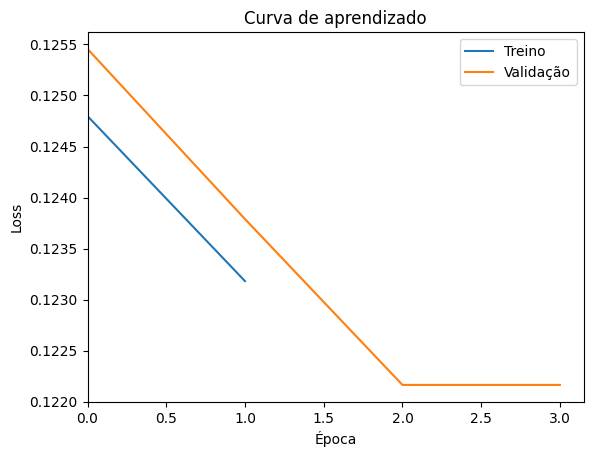

In [53]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")
#N VAI RODAR NO PCZINHO DA ILUM :(